# ECON 1923 Project 2: Product Differentiation

## 1 Preparation
### 1.1 Obtaining the data
Create a data set containing nutrition information about cereal boxes. You can use all sources including the nutrition APIs, stores web pages, actual grocery stores, your pantry, etc.
At the end of this process, you should have a dataframe that contains as many cereal boxes as possible and for each, you should have several nutri- tional facts and (ideally) serving sizes (cups or grams).
The result of this part can be several dataframes, each resulting from the different data sources that you used.

In [3]:
#packages and API keys
import requests, json
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
from sklearn.cluster import KMeans

%run APIkeys.py

In [4]:
# list of cereals from Professor Beresteanu's Github
url = "https://raw.githubusercontent.com/ArieBeresteanu/Econ1923_Fall2022/main/Cereal_Project/cereal_WholeFoods.json"

response = json.loads(requests.get(url).text)

In [5]:
type(response)
response.keys()

dict_keys(['information', 'cereal'])

In [6]:
# skipping the first entry
df = pd.DataFrame(response['cereal'])

In [7]:
# column names
df.columns

Index(['label', 'ENERC_KCAL', 'FAT', 'FASAT', 'FATRN', 'CHOLE', 'NA', 'Carb',
       'Fiber', 'SUGAR', 'SUGAR.added', 'Protein', 'VITD', 'P', 'Iron',
       'Calcium', 'servingSize_cup', 'servingSize_Gram', 'FAPOLY', 'FAMONO',
       'FOLAC', 'VitB6A', 'NIA', 'MG'],
      dtype='object')

In [8]:
info = ['label', 'ENERC_KCAL', 'FAT', 'NA', 'Carb', 'Fiber', 'SUGAR', 'Protein', 'Iron', 'Calcium', 'servingSize_cup', 'servingSize_Gram']

In [9]:
wholefoods_df = df[info]

In [10]:
wholefoods_df['dataSource'] = 'Whole Foods'

/var/folders/p4/58kv93497hj021_cs96lkwdw0000gn/T/ipykernel_31173/309598633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wholefoods_df['dataSource'] = 'Whole Foods'


In [11]:
# cereals from whole foods
wholefoods_df

,label,ENERC_KCAL,FAT,NA,Carb,Fiber,SUGAR,Protein,Iron,Calcium,servingSize_cup,servingSize_Gram,dataSource
0,"Purely Elizabeth, Original Ancient Grain Grano...",130,6.0,135,19.0,2.0,7.0,3.0,1.0,14.0,0.333,30.0,Whole Foods
1,"Catalina Crunch, Cinnamon Toast Cereal, 9 oz",110,5.0,110,14.0,9.0,0.0,11.0,1.6,50.0,NaN,36.0,Whole Foods
2,"Catalina Crunch, Dark Chocolate Cereal, 9 oz",110,6.0,125,14.0,9.0,0.0,11.0,2.3,50.0,NaN,36.0,Whole Foods
3,"Michele's Granola, Original Granola, 12 oz",150,9.0,0,15.0,2.0,6.0,3.0,1.0,20.0,0.250,28.0,Whole Foods
4,"365 by Whole Foods Market, Organic Cereal, Oat...",240,7.0,50,40.0,3.0,15.0,5.0,1.5,30.0,0.500,55.0,Whole Foods
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,"Arrowhead Mills, Organic Maple Buckwheat Flake...",140,1.0,160,31.0,2.0,7.0,3.0,0.9,0.0,1.000,43.0,Whole Foods
71,"Cascadian Farm, Organic Purely O's Cereal, 8.6 oz",140,1.5,240,29.0,4.0,1.0,4.0,0.8,60.0,0.500,38.0,Whole Foods
72,"Michele's Granola, Lemon Pistachio Granola, 12 oz",150,9.0,0,15.0,2.0,6.0,3.0,1.0,20.0,NaN,28.0,Whole Foods
73,"365 by Whole Foods Market, S'mores Granola, 12 oz",120,3.5,55,21.0,2.0,7.0,2.0,0.9,0.0,0.333,28.0,Whole Foods


In [12]:
# edamam API
edamam_id = os.environ['EDAMAM_API_id']
edamam_key = os.environ['EDAMAM_API_key']
#edama_baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+app_id+'&app_key='+key+'&upc='
#edama_endURL = '&nutrition-type=cooking&category=packaged-foods'

In [13]:
def checkUPC_edamam(upc):
    # This function is called checkUPC_V2 in previous notebooks
    
    edamam_id = os.environ['EDAMAM_API_id']
    edamam_key = os.environ['EDAMAM_API_key']
    edamam_baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+edamam_id+'&app_key='+edamam_key+'&upc='
    edamam_endURL = '&nutrition-type=cooking&category=packaged-foods'
    url = edamam_baseURL + upc + edamam_endURL
    info = requests.get(url).json()
    if 'error' in info:
        return info
    else:
        answer = info['hints'][0]['food']['nutrients']
        
        sizeList = info['hints'][0]['food']['servingSizes']
        n = len(sizeList)
        for i in range(n):
            if sizeList[i]['label'] == 'Gram':
                answer['servingSize_gram'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
            if sizeList[i]['label'] == 'Cup':
                answer['servingSize_cup'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
        
        answer['label'] = info['hints'][0]['food']['label']
        answer['upc'] = upc
        return answer

In [14]:
def multiUPC_edamam(shelf, verbose = False, leftovers = False, source=""):
    # This function is called multiUPC_V2 in previous notebooks
    
    # Shelf - a list of strings, each representing a UPC code
    # verbose - boolean telling the function whether to print found/unfound UPCs
    # leftovers - boolean telling the function whetehr to output the 
    
    found = []    #container for information on found UPCS
    unfound = []  #container for unfound UPCs
    
    # loop over UPCs in shelf
    for upc in shelf:
        info = checkUPC_edamam(upc)
        
        if 'error' in info:
            unfound.append(upc) #add to the unfound container
            if verbose:
                print('UPC ',upc, ' does not exist in the API\'s data base')
        
        else:
            if verbose:
                print('UPC ',upc, ' exists in the API\'s data base')
            found.append(info)
    
    # turn the dictionary found into a Dataframe
    if len(found)>0:
        df_found = pd.DataFrame(found)
    else:
        df_found = pd.DataFrame()
    
    # add a source column
    df_found["dataSource"] = pd.Series([source for i in range(len(df_found.index))])
    
    
    # return the values of found and unfound (optional)
    if leftovers:
        return df_found,unfound
    else:
        return df_found

In [15]:
GE_WF_UPCSs = ["016000124790", "016000122543", "016000125063", "016000123991", "016000487727", "030000060834", "016000124950", "016000125933", "016000275157", "016000124998", "16000487949", "30000063224", "884912004710", "16000487932", "884912014269", "30000063545", "884912129659", "16000103719", "38000199240", "16000163461", "38000198717", "884912111715", "884912249265", "16000126855", "884912126115", "16000120259", "884912002372", "38000200458", "16000163614", "30000064306", "884912102102", "16000152335", "884912116505", "16000275638", "43000129715", "16000157811", "38000787041", "16000121836", "21908455563", "43000129517", "884912126016", "16000163669", "30000061534", "30034019082", "884912249272", "13562002474", "884912117625", "43000014271", "884912114600", "38000200663"]

print(f"The list of UPCs contains {len(GE_WF_UPCSs)} UPCs")

The list of UPCs contains 50 UPCs


In [16]:
def unique(list_in):
    # converting a list to a set and then back to a list gets rid of duplicates
    return list(set(list_in))

In [17]:
print(f"The list of UPCs contains {len(unique(GE_WF_UPCSs))} unique UPCs")

The list of UPCs contains 50 unique UPCs


In [18]:
GE_cereal, GE_leftovers = multiUPC_edamam(GE_WF_UPCSs, verbose = True, leftovers = True, source = "Giant_Eagle_WF")

UPC  016000124790  exists in the API's data base
UPC  016000122543  exists in the API's data base
UPC  016000125063  exists in the API's data base
UPC  016000123991  exists in the API's data base
UPC  016000487727  exists in the API's data base
UPC  030000060834  exists in the API's data base
UPC  016000124950  exists in the API's data base
UPC  016000125933  exists in the API's data base
UPC  016000275157  exists in the API's data base
UPC  016000124998  exists in the API's data base
UPC  16000487949  exists in the API's data base
UPC  30000063224  exists in the API's data base
UPC  884912004710  exists in the API's data base
UPC  16000487932  exists in the API's data base
UPC  884912014269  exists in the API's data base
UPC  30000063545  exists in the API's data base
UPC  884912129659  exists in the API's data base
UPC  16000103719  exists in the API's data base
UPC  38000199240  exists in the API's data base
UPC  16000163461  does not exist in the API's data base
UPC  38000198717  e

In [19]:
print(f"Out of {len(GE_WF_UPCSs)} cereals, we found {GE_cereal.shape[0]} cereals and we didn't find {len(GE_leftovers)} cereals")

Out of 50 cereals, we found 45 cereals and we didn't find 5 cereals


In [20]:
# The UPCs that were not found
GE_leftovers

['16000163461', '16000120259', '16000163614', '16000121836', '16000163669']

In [21]:
GE_cereal.columns

Index(['ENERC_KCAL', 'FAT', 'FASAT', 'FATRN', 'FAMS', 'FAPU', 'CHOCDF',
       'FIBTG', 'SUGAR', 'PROCNT', 'CHOLE', 'NA', 'CA', 'MG', 'K', 'FE', 'ZN',
       'P', 'VITC', 'THIA', 'RIBF', 'VITB6A', 'VITB12', 'servingSize_cup',
       'servingSize_gram', 'label', 'upc', 'NIA', 'FOLAC', 'VITD',
       'SUGAR.added', 'TOCPHA', 'FOLDFE', 'dataSource'],
      dtype='object')

In [22]:
gianteagle_df = GE_cereal[['label', 'ENERC_KCAL', 'FAT', 'NA', 'CHOCDF', 'FIBTG', 'SUGAR', 'PROCNT', 'FE', 'CA', 'servingSize_cup', 'servingSize_gram', 'upc', 'dataSource']]
#['label', 'ENERC_KCAL', 'FAT', 'CHOLE', 'NA', 'Carb', 'Fiber', 'SUGAR', 'Protein', 'Iron', 'Calcium', 'servingSize_cup', 'servingSize_Gram']

In [23]:
# cereals from giant eagle
# get rid of duplicates!
gianteagle_df

,label,ENERC_KCAL,FAT,NA,CHOCDF,FIBTG,SUGAR,PROCNT,FE,CA,servingSize_cup,servingSize_gram,upc,dataSource
0,Honey Nut Cheerios,393.000000,5.360000,571.000000,78.570000,7.100000,32.139999,7.140000,16.070000,357.000000,0.75,28.0,016000124790,Giant_Eagle_WF
1,Cinnamon Toast Crunch Cereal,419.000000,9.680000,581.000000,80.650002,6.500000,29.030001,3.230000,14.520000,323.000000,0.75,31.0,016000122543,Giant_Eagle_WF
2,Honey Nut Cheerios,393.000000,5.360000,571.000000,78.570000,7.100000,32.139999,7.140000,16.070000,357.000000,0.75,28.0,016000125063,Giant_Eagle_WF
3,"Lucky Charms Cereal Frosted Toasted Oat, With ...",407.407407,3.703704,629.629630,81.481481,7.407407,37.037037,7.407407,16.666667,370.370370,0.75,27.0,016000123991,Giant_Eagle_WF
4,Cheerios Cereal,357.000000,7.140000,500.000000,71.430000,10.700000,3.570000,10.710000,28.930000,357.000000,1.00,28.0,016000487727,Giant_Eagle_WF
5,"Cinnamon Multigrain Cereal, Cinnamon",375.000000,4.690000,469.000000,78.120003,6.200000,25.000000,9.380000,22.500000,312.000000,0.75,32.0,030000060834,Giant_Eagle_WF
6,Honey Nut Cheerios Cereal,393.000000,5.360000,571.000000,78.570000,7.100000,32.139999,7.140000,16.070000,357.000000,0.75,28.0,016000124950,Giant_Eagle_WF
7,Cinnamon Toast Crunch Cereal,419.000000,9.680000,581.000000,80.650002,6.500000,29.030001,3.230000,14.520000,323.000000,0.75,31.0,016000125933,Giant_Eagle_WF
8,Cheerios Multi Grain Lightly Sweetned Cereal,379.310345,3.448276,413.793103,82.758621,10.344828,0.000000,6.896552,NaN,NaN,1.00,29.0,016000275157,Giant_Eagle_WF
9,"Lucky Charms Cereal Large Size, 14.9 Oz",407.407407,3.703704,629.629630,81.481481,7.407407,37.037037,7.407407,16.666667,370.370370,0.75,27.0,016000124998,Giant_Eagle_WF


In [24]:
# use nutritionix API to get nutrition facts for the Giant Eagle cereals that didn't exist in the Edamam API
nutritionix_id = os.environ["NUTRITIONIX_API_id"]
nutritionix_key = os.environ["NUTRITIONIX_API_key"]


In [25]:
nutritionix_baseURL = "https://trackapi.nutritionix.com/v2/search/item?upc="

nutritionix_HEADERS = {
    "x-app-id" : nutritionix_id,
    "x-app-key" : nutritionix_key,
    "Content-Type" : "application/json"
}

In [26]:
def inquiry(upc,source=""):
    try:        
        url = nutritionix_baseURL+upc
        r = requests.get(url, headers=nutritionix_HEADERS).json()
        r2 = r["foods"][0]
        r2["UPC"]  = upc
        r2["source"] = source
        return r2
    except:
        return "UPC could not be found"

In [27]:
def translate_N2E(d):
    #this function gets a reply from Nutrtionix API in a form of a dictionary 
    # and translates it into a dictionary in the form of Edamam's API

    iron = None
    ca = None
    trans = None
    vitd = None
    sugr_ad = None
    lb = d["brand_name"] + ", " + d["food_name"]
    
    for dd in d["full_nutrients"]:
        attr_id = dd["attr_id"]
        val = dd["value"]
        if attr_id == 303:
            iron = val        
        elif attr_id == 301:
            ca = val
        elif attr_id == 605:
            trans = val
        elif attr_id == 324:
            vitd = val
        elif attr_id == 539:
            sugr_ad = val
        
    new_d = {
        "label" : lb,
        "ENERC_KCAL" : d["nf_calories"],
        "FAT" : d["nf_total_fat"],
        "NA" : d["nf_sodium"],
        "CHOCDF" : d["nf_total_carbohydrate"],
        "FIBTG" : d["nf_dietary_fiber"],
        "SUGAR" : d["nf_sugars"],
        "PROCNT" : d["nf_protein"],
        "VITD" : vitd,
        "P" : d["nf_potassium"],
        "FE" : iron,
        "CA" : ca,
        "servingSize_cup" : d["serving_qty"],
        "servingSize_gram" : d["serving_weight_grams"],
        "upc" : d["UPC"],
        "dataSource" : d["source"]
        }
    
    return new_d

In [28]:
def multiUPC_nutritionix(UPCs,source=""):
    # This function takes a list of UPCs (usually leftovers from the another API)
    # then it search the nutriotionix API for each UPC in the list. If the UPC
    # exists it translates the information to the same dictionary format of the
    # Edamam API and appends it to the list of found cereals and outputs it
    
    data =[]
    
    for upc in UPCs:
        d = inquiry(upc,source=source)
        if type(d) == dict:
            d2 = translate_N2E(d)
            data.append(d2)
        else:
            print(f"UPC {upc} was not found on Nutrionix API")
        
    return pd.DataFrame(data)

In [29]:
df_GE_add = multiUPC_nutritionix(GE_leftovers,source="Giant_Eagle_WF")

In [30]:
df_GE_add

,label,ENERC_KCAL,FAT,NA,CHOCDF,FIBTG,SUGAR,PROCNT,VITD,P,FE,CA,servingSize_cup,servingSize_gram,upc,dataSource
0,"General Mills, Apple Cinnamon Cheerios Whole G...",150,2.5,150,30,3,12,3,NaN,0,3.6,130,1,37,16000163461,Giant_Eagle_WF
1,"Golden Grahams, Cereal",160,1.0,300,34,2,12,2,80.0,0,3.6,130,1,40,16000120259,Giant_Eagle_WF
2,"Cheerios, Cinnamon Oat Crunch Sweetened Multig...",220,5.0,230,42,3,15,4,80.0,160,10.8,130,1,54,16000163614,Giant_Eagle_WF
3,"General Mills, Frosted Toasted Oat Cereal wit ...",140,1.5,230,30,2,12,3,80.0,0,3.6,130,1,36,16000121836,Giant_Eagle_WF
4,"Cheerios, Chocolate Peanut Butter Whole Grain ...",150,4.5,230,25,3,9,4,80.0,160,3.6,130,1,36,16000163669,Giant_Eagle_WF


In [31]:
# add these cereals to the dataframe of Giant Eagle cereals
gianteagle = gianteagle_df.append(df_GE_add, ignore_index = True)

/var/folders/p4/58kv93497hj021_cs96lkwdw0000gn/T/ipykernel_31173/2541632563.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gianteagle = gianteagle_df.append(df_GE_add, ignore_index = True)


In [32]:
gianteagle

,label,ENERC_KCAL,FAT,NA,CHOCDF,FIBTG,SUGAR,PROCNT,FE,CA,servingSize_cup,servingSize_gram,upc,dataSource,VITD,P
0,Honey Nut Cheerios,393.000000,5.360000,571.000000,78.570000,7.100000,32.139999,7.140000,16.070000,357.000000,0.75,28.0,016000124790,Giant_Eagle_WF,NaN,NaN
1,Cinnamon Toast Crunch Cereal,419.000000,9.680000,581.000000,80.650002,6.500000,29.030001,3.230000,14.520000,323.000000,0.75,31.0,016000122543,Giant_Eagle_WF,NaN,NaN
2,Honey Nut Cheerios,393.000000,5.360000,571.000000,78.570000,7.100000,32.139999,7.140000,16.070000,357.000000,0.75,28.0,016000125063,Giant_Eagle_WF,NaN,NaN
3,"Lucky Charms Cereal Frosted Toasted Oat, With ...",407.407407,3.703704,629.629630,81.481481,7.407407,37.037037,7.407407,16.666667,370.370370,0.75,27.0,016000123991,Giant_Eagle_WF,NaN,NaN
4,Cheerios Cereal,357.000000,7.140000,500.000000,71.430000,10.700000,3.570000,10.710000,28.930000,357.000000,1.00,28.0,016000487727,Giant_Eagle_WF,NaN,NaN
5,"Cinnamon Multigrain Cereal, Cinnamon",375.000000,4.690000,469.000000,78.120003,6.200000,25.000000,9.380000,22.500000,312.000000,0.75,32.0,030000060834,Giant_Eagle_WF,NaN,NaN
6,Honey Nut Cheerios Cereal,393.000000,5.360000,571.000000,78.570000,7.100000,32.139999,7.140000,16.070000,357.000000,0.75,28.0,016000124950,Giant_Eagle_WF,NaN,NaN
7,Cinnamon Toast Crunch Cereal,419.000000,9.680000,581.000000,80.650002,6.500000,29.030001,3.230000,14.520000,323.000000,0.75,31.0,016000125933,Giant_Eagle_WF,NaN,NaN
8,Cheerios Multi Grain Lightly Sweetned Cereal,379.310345,3.448276,413.793103,82.758621,10.344828,0.000000,6.896552,NaN,NaN,1.00,29.0,016000275157,Giant_Eagle_WF,NaN,NaN
9,"Lucky Charms Cereal Large Size, 14.9 Oz",407.407407,3.703704,629.629630,81.481481,7.407407,37.037037,7.407407,16.666667,370.370370,0.75,27.0,016000124998,Giant_Eagle_WF,NaN,NaN


In [33]:
pd.set_option('display.max_rows', None)
wholefoods_df

,label,ENERC_KCAL,FAT,NA,Carb,Fiber,SUGAR,Protein,Iron,Calcium,servingSize_cup,servingSize_Gram,dataSource
0,"Purely Elizabeth, Original Ancient Grain Grano...",130,6.0,135,19.0,2.0,7.0,3.0,1.00,14.0,0.333,30.0,Whole Foods
1,"Catalina Crunch, Cinnamon Toast Cereal, 9 oz",110,5.0,110,14.0,9.0,0.0,11.0,1.60,50.0,NaN,36.0,Whole Foods
2,"Catalina Crunch, Dark Chocolate Cereal, 9 oz",110,6.0,125,14.0,9.0,0.0,11.0,2.30,50.0,NaN,36.0,Whole Foods
3,"Michele's Granola, Original Granola, 12 oz",150,9.0,0,15.0,2.0,6.0,3.0,1.00,20.0,0.250,28.0,Whole Foods
4,"365 by Whole Foods Market, Organic Cereal, Oat...",240,7.0,50,40.0,3.0,15.0,5.0,1.50,30.0,0.500,55.0,Whole Foods
5,"Nature's Path Organic, Heritage Flakes Cereal,...",160,1.5,170,31.0,7.0,5.0,5.0,2.00,0.0,1.000,40.0,Whole Foods
6,"Cheerios Honey Nut , 15.4 oz",180,2.0,210,30.0,3.0,12.0,3.0,3.60,130.0,1.000,37.0,Whole Foods
7,"Nature's Path Organic, Heritage Flakes Cereal,...",160,1.5,170,31.0,7.0,5.0,5.0,2.00,0.0,1.000,40.0,Whole Foods
8,"Cascadian Farm, Organic Cinnamon Crunch Cereal...",180,3.0,140,29.0,3.0,11.0,2.0,1.00,0.0,1.000,36.0,Whole Foods
9,"365 by Whole Foods Market, Granola Maple Almon...",260,9.0,115,38.0,4.0,11.0,7.0,1.80,60.0,0.667,NaN,Whole Foods


In [34]:
# get list of manually entered cereals from Georgia's Github
url1 = "https://raw.githubusercontent.com/georgiawright1/project2/main/trader%20joe's"

cereals = json.loads(requests.get(url1).text)

In [35]:
type(cereals)

dict

In [36]:
# create dataframe of trader joe's cereals
df1 = pd.DataFrame(cereals['tjs'])

In [37]:
# reorder nutrition facts to match other dateframes
traderjoes = df1[['label', 'ENERC_KCAL', 'FAT', 'NA', 'Carb', 'Fiber', 'SUGAR', 'Protein', 'Iron', 'Calcium', 'servingSize_cup', 'servingSize_gram', 'dataSource']]

In [38]:
traderjoes

,label,ENERC_KCAL,FAT,NA,Carb,Fiber,SUGAR,Protein,Iron,Calcium,servingSize_cup,servingSize_gram,dataSource
0,Crispy Rice Cereal,150,0.0,170,35.0,0.0,4.0,3.0,0.3,0.0,NaN,40.0,Trader Joe's
1,Almond Butter Puffs Cereal,200,10.0,80,20.0,2.0,6.0,6.0,1.2,60.0,NaN,40.0,Trader Joe's
2,Honey O's Cereal,160,2.0,210,34.0,2.0,14.0,3.0,5.4,10.0,NaN,41.0,Trader Joe's
3,Joe's O's Cereal,160,2.5,170,31.0,4.0,2.0,5.0,8.1,20.0,NaN,41.0,Trader Joe's
4,Strawberry Yogurt O's,120,2.0,95,22.0,1.0,8.0,2.0,5.0,61.0,0.75,NaN,Trader Joe's
5,Maple Pecan Clusters Cereal,230,7.0,140,39.0,3.0,11.0,4.0,1.1,0.0,NaN,53.0,Trader Joe's
6,Crunchy Cinnamon Squares,160,2.5,300,32.0,3.0,10.0,4.0,5.8,130.0,NaN,40.0,Trader Joe's


### 1.2 Cleaning and re-scaling
Various data sources may contain different variable names, different units, or different serving sizes. Also, missing values can be an issue. Here, you are asked to:
- Make sure that variable names in all dataframes that you created match.
- Make sure that all nutritional measurements in all data frames are the same (e.g. per cup or per 100gr). 
- Merge the different data sources.
The final data set should include a column indicating the source of the observation (i.e. is it from the API, entered manually from a certain store, etc.).

In [39]:
# rename giant eagle columns so that column names match
gianteagle = gianteagle.rename(columns={'CHOCDF': 'Carb', 'FIBTG': 'Fiber', 'PROCNT':'Protein', 'FE': 'Iron', 'CA': "Calcium"})



In [40]:
# reordering colums
gianteagle2= gianteagle[['label', 'ENERC_KCAL', 'FAT', 'NA', 'Carb', 'Fiber', 'SUGAR', 'Protein', 'Iron', 'Calcium', 'servingSize_cup', 'servingSize_gram', 'upc', 'dataSource']]

In [41]:
gianteagle2

,label,ENERC_KCAL,FAT,NA,Carb,Fiber,SUGAR,Protein,Iron,Calcium,servingSize_cup,servingSize_gram,upc,dataSource
0,Honey Nut Cheerios,393.000000,5.360000,571.000000,78.570000,7.100000,32.139999,7.140000,16.070000,357.000000,0.75,28.0,016000124790,Giant_Eagle_WF
1,Cinnamon Toast Crunch Cereal,419.000000,9.680000,581.000000,80.650002,6.500000,29.030001,3.230000,14.520000,323.000000,0.75,31.0,016000122543,Giant_Eagle_WF
2,Honey Nut Cheerios,393.000000,5.360000,571.000000,78.570000,7.100000,32.139999,7.140000,16.070000,357.000000,0.75,28.0,016000125063,Giant_Eagle_WF
3,"Lucky Charms Cereal Frosted Toasted Oat, With ...",407.407407,3.703704,629.629630,81.481481,7.407407,37.037037,7.407407,16.666667,370.370370,0.75,27.0,016000123991,Giant_Eagle_WF
4,Cheerios Cereal,357.000000,7.140000,500.000000,71.430000,10.700000,3.570000,10.710000,28.930000,357.000000,1.00,28.0,016000487727,Giant_Eagle_WF
5,"Cinnamon Multigrain Cereal, Cinnamon",375.000000,4.690000,469.000000,78.120003,6.200000,25.000000,9.380000,22.500000,312.000000,0.75,32.0,030000060834,Giant_Eagle_WF
6,Honey Nut Cheerios Cereal,393.000000,5.360000,571.000000,78.570000,7.100000,32.139999,7.140000,16.070000,357.000000,0.75,28.0,016000124950,Giant_Eagle_WF
7,Cinnamon Toast Crunch Cereal,419.000000,9.680000,581.000000,80.650002,6.500000,29.030001,3.230000,14.520000,323.000000,0.75,31.0,016000125933,Giant_Eagle_WF
8,Cheerios Multi Grain Lightly Sweetned Cereal,379.310345,3.448276,413.793103,82.758621,10.344828,0.000000,6.896552,NaN,NaN,1.00,29.0,016000275157,Giant_Eagle_WF
9,"Lucky Charms Cereal Large Size, 14.9 Oz",407.407407,3.703704,629.629630,81.481481,7.407407,37.037037,7.407407,16.666667,370.370370,0.75,27.0,016000124998,Giant_Eagle_WF


In [42]:
# rename wholefoods_df columns so match with gianteagle
wholefoods_df = wholefoods_df.rename(columns={'servingSize_Gram':'servingSize_gram'})

In [43]:
wholefoods_df

,label,ENERC_KCAL,FAT,NA,Carb,Fiber,SUGAR,Protein,Iron,Calcium,servingSize_cup,servingSize_gram,dataSource
0,"Purely Elizabeth, Original Ancient Grain Grano...",130,6.0,135,19.0,2.0,7.0,3.0,1.00,14.0,0.333,30.0,Whole Foods
1,"Catalina Crunch, Cinnamon Toast Cereal, 9 oz",110,5.0,110,14.0,9.0,0.0,11.0,1.60,50.0,NaN,36.0,Whole Foods
2,"Catalina Crunch, Dark Chocolate Cereal, 9 oz",110,6.0,125,14.0,9.0,0.0,11.0,2.30,50.0,NaN,36.0,Whole Foods
3,"Michele's Granola, Original Granola, 12 oz",150,9.0,0,15.0,2.0,6.0,3.0,1.00,20.0,0.250,28.0,Whole Foods
4,"365 by Whole Foods Market, Organic Cereal, Oat...",240,7.0,50,40.0,3.0,15.0,5.0,1.50,30.0,0.500,55.0,Whole Foods
5,"Nature's Path Organic, Heritage Flakes Cereal,...",160,1.5,170,31.0,7.0,5.0,5.0,2.00,0.0,1.000,40.0,Whole Foods
6,"Cheerios Honey Nut , 15.4 oz",180,2.0,210,30.0,3.0,12.0,3.0,3.60,130.0,1.000,37.0,Whole Foods
7,"Nature's Path Organic, Heritage Flakes Cereal,...",160,1.5,170,31.0,7.0,5.0,5.0,2.00,0.0,1.000,40.0,Whole Foods
8,"Cascadian Farm, Organic Cinnamon Crunch Cereal...",180,3.0,140,29.0,3.0,11.0,2.0,1.00,0.0,1.000,36.0,Whole Foods
9,"365 by Whole Foods Market, Granola Maple Almon...",260,9.0,115,38.0,4.0,11.0,7.0,1.80,60.0,0.667,NaN,Whole Foods


In [44]:
# checking for duplicates in Giant Eagle df
# list of upcs from Professor Beresteanu's Github:
GE_WF_UPCSs = ["016000124790", "016000122543", "016000125063", "016000123991", "016000487727", "030000060834", "016000124950", "016000125933", "016000275157", "016000124998", "16000487949", "30000063224", "884912004710", "16000487932", "884912014269", "30000063545", "884912129659", "16000103719", "38000199240", "16000163461", "38000198717", "884912111715", "884912249265", "16000126855", "884912126115", "16000120259", "884912002372", "38000200458", "16000163614", "30000064306", "884912102102", "16000152335", "884912116505", "16000275638", "43000129715", "16000157811", "38000787041", "16000121836", "21908455563", "43000129517", "884912126016", "16000163669", "30000061534", "30034019082", "884912249272", "13562002474", "884912117625", "43000014271", "884912114600", "38000200663"]

In [45]:
def unique(list_in):
    # converting a list to a set and then back to a list gets rid of duplicates
    return list(set(list_in))

In [46]:
# number of unique UPCs in list out of 50
print(f"The list of UPCs contains {len(unique(GE_WF_UPCSs))} unique UPCs")

The list of UPCs contains 50 unique UPCs


In [47]:
# combine gianteagle and wholefoods_df 
wf_ge = wholefoods_df.append(gianteagle2, ignore_index = True)

/var/folders/p4/58kv93497hj021_cs96lkwdw0000gn/T/ipykernel_31173/1571339663.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wf_ge = wholefoods_df.append(gianteagle2, ignore_index = True)


In [48]:
wf_ge

,label,ENERC_KCAL,FAT,NA,Carb,Fiber,SUGAR,Protein,Iron,Calcium,servingSize_cup,servingSize_gram,dataSource,upc
0,"Purely Elizabeth, Original Ancient Grain Grano...",130.000000,6.000000,135.000000,19.000000,2.000000,7.000000,3.000000,1.000000,14.000000,0.333,30.0,Whole Foods,NaN
1,"Catalina Crunch, Cinnamon Toast Cereal, 9 oz",110.000000,5.000000,110.000000,14.000000,9.000000,0.000000,11.000000,1.600000,50.000000,NaN,36.0,Whole Foods,NaN
2,"Catalina Crunch, Dark Chocolate Cereal, 9 oz",110.000000,6.000000,125.000000,14.000000,9.000000,0.000000,11.000000,2.300000,50.000000,NaN,36.0,Whole Foods,NaN
3,"Michele's Granola, Original Granola, 12 oz",150.000000,9.000000,0.000000,15.000000,2.000000,6.000000,3.000000,1.000000,20.000000,0.250,28.0,Whole Foods,NaN
4,"365 by Whole Foods Market, Organic Cereal, Oat...",240.000000,7.000000,50.000000,40.000000,3.000000,15.000000,5.000000,1.500000,30.000000,0.500,55.0,Whole Foods,NaN
5,"Nature's Path Organic, Heritage Flakes Cereal,...",160.000000,1.500000,170.000000,31.000000,7.000000,5.000000,5.000000,2.000000,0.000000,1.000,40.0,Whole Foods,NaN
6,"Cheerios Honey Nut , 15.4 oz",180.000000,2.000000,210.000000,30.000000,3.000000,12.000000,3.000000,3.600000,130.000000,1.000,37.0,Whole Foods,NaN
7,"Nature's Path Organic, Heritage Flakes Cereal,...",160.000000,1.500000,170.000000,31.000000,7.000000,5.000000,5.000000,2.000000,0.000000,1.000,40.0,Whole Foods,NaN
8,"Cascadian Farm, Organic Cinnamon Crunch Cereal...",180.000000,3.000000,140.000000,29.000000,3.000000,11.000000,2.000000,1.000000,0.000000,1.000,36.0,Whole Foods,NaN
9,"365 by Whole Foods Market, Granola Maple Almon...",260.000000,9.000000,115.000000,38.000000,4.000000,11.000000,7.000000,1.800000,60.000000,0.667,NaN,Whole Foods,NaN


In [49]:
# combine gianteagle and wholefoods_df dataframes with traderjoes
cereal = wf_ge.append(traderjoes, ignore_index = True)

/var/folders/p4/58kv93497hj021_cs96lkwdw0000gn/T/ipykernel_31173/2269759651.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cereal = wf_ge.append(traderjoes, ignore_index = True)


In [50]:
cereal

,label,ENERC_KCAL,FAT,NA,Carb,Fiber,SUGAR,Protein,Iron,Calcium,servingSize_cup,servingSize_gram,dataSource,upc
0,"Purely Elizabeth, Original Ancient Grain Grano...",130.000000,6.000000,135.000000,19.000000,2.000000,7.000000,3.000000,1.000000,14.000000,0.333,30.0,Whole Foods,NaN
1,"Catalina Crunch, Cinnamon Toast Cereal, 9 oz",110.000000,5.000000,110.000000,14.000000,9.000000,0.000000,11.000000,1.600000,50.000000,NaN,36.0,Whole Foods,NaN
2,"Catalina Crunch, Dark Chocolate Cereal, 9 oz",110.000000,6.000000,125.000000,14.000000,9.000000,0.000000,11.000000,2.300000,50.000000,NaN,36.0,Whole Foods,NaN
3,"Michele's Granola, Original Granola, 12 oz",150.000000,9.000000,0.000000,15.000000,2.000000,6.000000,3.000000,1.000000,20.000000,0.250,28.0,Whole Foods,NaN
4,"365 by Whole Foods Market, Organic Cereal, Oat...",240.000000,7.000000,50.000000,40.000000,3.000000,15.000000,5.000000,1.500000,30.000000,0.500,55.0,Whole Foods,NaN
5,"Nature's Path Organic, Heritage Flakes Cereal,...",160.000000,1.500000,170.000000,31.000000,7.000000,5.000000,5.000000,2.000000,0.000000,1.000,40.0,Whole Foods,NaN
6,"Cheerios Honey Nut , 15.4 oz",180.000000,2.000000,210.000000,30.000000,3.000000,12.000000,3.000000,3.600000,130.000000,1.000,37.0,Whole Foods,NaN
7,"Nature's Path Organic, Heritage Flakes Cereal,...",160.000000,1.500000,170.000000,31.000000,7.000000,5.000000,5.000000,2.000000,0.000000,1.000,40.0,Whole Foods,NaN
8,"Cascadian Farm, Organic Cinnamon Crunch Cereal...",180.000000,3.000000,140.000000,29.000000,3.000000,11.000000,2.000000,1.000000,0.000000,1.000,36.0,Whole Foods,NaN
9,"365 by Whole Foods Market, Granola Maple Almon...",260.000000,9.000000,115.000000,38.000000,4.000000,11.000000,7.000000,1.800000,60.000000,0.667,NaN,Whole Foods,NaN


In [51]:
# # Rescaling to 100 gms
# for index, row in cereal.iterrows():
#     scalar = 100/row['servingSize_gram']
#     cereal.at[index, 'servingSize_gram'] = (cereal.at[index, 'servingSize_gram'])*scalar
#     cereal.at[index, 'servingSize_cup'] = (cereal.at[index, 'servingSize_cup'])*scalar
#     cereal.at[index, 'ENERC_KCAL'] = (cereal.at[index, 'ENERC_KCAL'])*scalar
#     cereal.at[index, 'FAT'] = (cereal.at[index, 'FAT'])*scalar
#     cereal.at[index, 'NA'] = (cereal.at[index, 'NA'])*scalar
#     cereal.at[index, 'Carb'] = (cereal.at[index, 'Carb'])*scalar
#     cereal.at[index, 'Fiber'] = (cereal.at[index, 'Fiber'])*scalar
#     cereal.at[index, 'SUGAR'] = (cereal.at[index, 'SUGAR'])*scalar
#     cereal.at[index, 'Protein'] = (cereal.at[index, 'Protein'])*scalar
#     cereal.at[index, 'Iron'] = (cereal.at[index, 'Iron'])*scalar
#     cereal.at[index, 'Calcium'] = (cereal.at[index, 'Calcium'])*scalar

# cereal

### 1.3 Descriptive statistics
Create a table with descriptive statistics (Mean, Median, standard deviation, range, number of missing observations, etc.

In [52]:
# descriptive statistics
cereal.describe()

,ENERC_KCAL,FAT,NA,Carb,Fiber,SUGAR,Protein,Iron,Calcium,servingSize_cup,servingSize_gram
count,132.000000,132.000000,132.000000,132.000000,130.000000,130.000000,132.000000,128.000000,124.000000,107.000000,128.000000
mean,241.707870,4.750944,248.565546,46.917863,4.895429,13.593301,5.580469,7.492769,78.524335,0.801402,41.794531
std,110.385008,3.645438,193.067782,25.570862,2.956071,10.540908,3.161219,10.146626,111.230616,0.276083,11.329248
min,101.442068,0.000000,0.000000,7.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.250000,27.000000
25%,150.000000,2.000000,110.000000,29.750000,2.125000,6.000000,3.000000,1.000000,10.000000,0.667000,32.000000
50%,200.000000,4.070000,190.000000,36.000000,4.000000,11.000000,5.000000,2.000000,30.000000,1.000000,40.000000
75%,373.500000,7.000000,396.500000,78.232502,7.000000,18.702411,7.320000,10.912500,100.000000,1.000000,53.250000
max,479.166667,18.750000,814.814815,110.000000,14.800000,55.259998,25.420000,39.509998,393.000000,1.333000,65.000000


In [53]:
# number of missing observations
len(cereal.index) - cereal.count()

label                0
ENERC_KCAL           0
FAT                  0
NA                   0
Carb                 0
Fiber                2
SUGAR                2
Protein              0
Iron                 4
Calcium              8
servingSize_cup     25
servingSize_gram     4
dataSource           0
upc                 82
dtype: int64

## 2 Market Analysis 
### 2.1 Visualisation
Create scatter plots of the data. Here you have to try several pairs of char- acteristics on which it seems like the products are more differentiated. This is a visual exercise but you can support your claims by looking at standard deviations and correlations.

In [54]:
# correlation matrix
cereal.corr()

,ENERC_KCAL,FAT,NA,Carb,Fiber,SUGAR,Protein,Iron,Calcium,servingSize_cup,servingSize_gram
ENERC_KCAL,1.000000,0.310708,0.798500,0.902852,0.501077,0.732846,0.469108,0.733813,0.546342,0.247831,-0.038613
FAT,0.310708,1.000000,-0.056812,0.082207,0.139974,0.062830,0.140655,0.115485,0.142786,-0.356526,-0.089623
NA,0.798500,-0.056812,1.000000,0.814080,0.411623,0.664393,0.312797,0.716421,0.695190,0.315691,-0.233118
Carb,0.902852,0.082207,0.814080,1.000000,0.498206,0.724987,0.379931,0.685934,0.460062,0.292410,-0.045585
Fiber,0.501077,0.139974,0.411623,0.498206,1.000000,0.185681,0.647875,0.468570,0.262629,0.176847,0.171588
SUGAR,0.732846,0.062830,0.664393,0.724987,0.185681,1.000000,0.131107,0.437148,0.468222,0.213132,-0.096406
Protein,0.469108,0.140655,0.312797,0.379931,0.647875,0.131107,1.000000,0.498326,0.279828,0.198147,0.285185
Iron,0.733813,0.115485,0.716421,0.685934,0.468570,0.437148,0.498326,1.000000,0.456841,0.165387,-0.045464
Calcium,0.546342,0.142786,0.695190,0.460062,0.262629,0.468222,0.279828,0.456841,1.000000,0.076200,-0.357133
servingSize_cup,0.247831,-0.356526,0.315691,0.292410,0.176847,0.213132,0.198147,0.165387,0.076200,1.000000,0.307450


In [55]:
# on which products are the products more differentiated?

# carbs, fat .0822
# protein, fat .140655
# protein, sugar .1311
# fat, sodium -.0568
# fat, fiber .13997
# fat, sugar .0628
# fat, iron .1155
#calcium, fat .1428

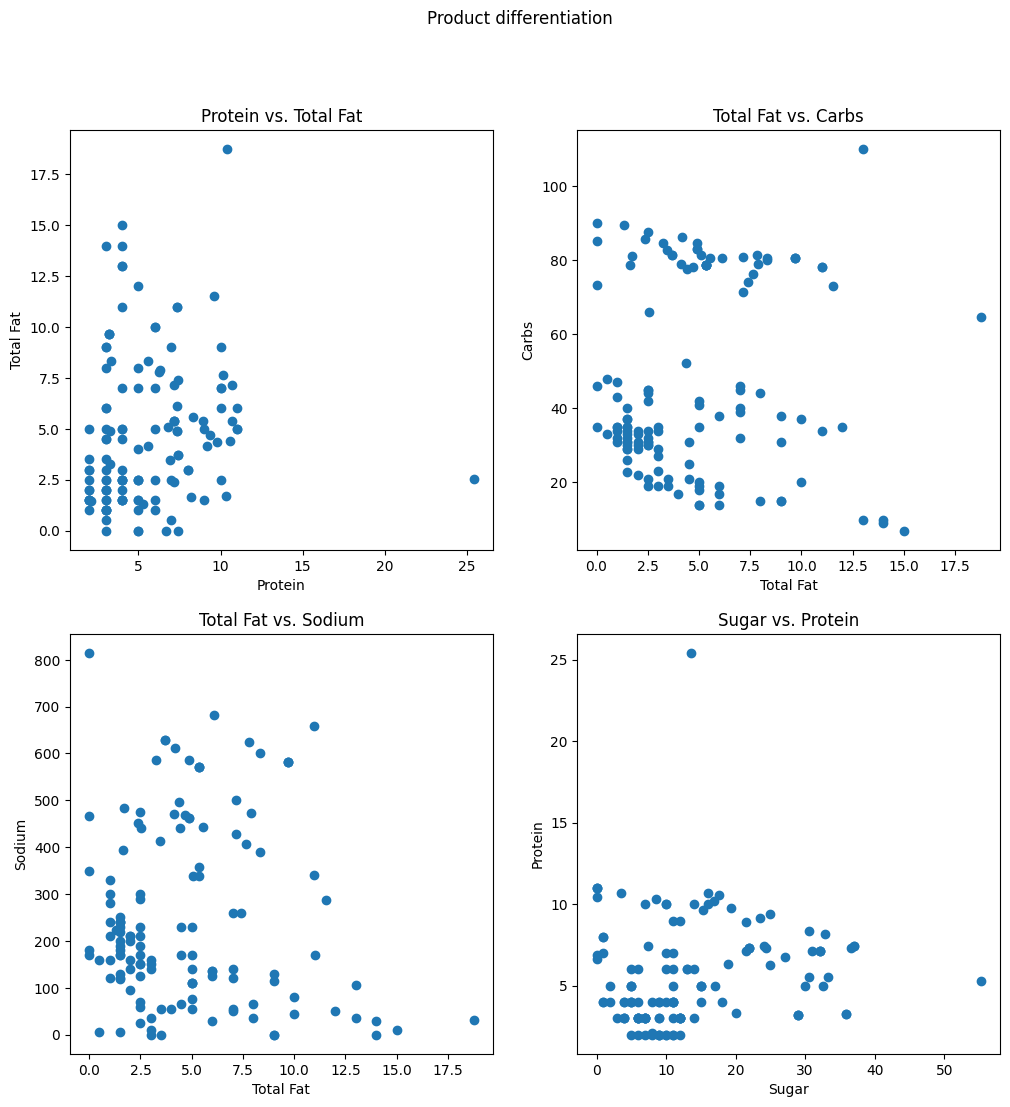

In [56]:
# scatter plots for protein:fat, fat:carbs, fat:sodium, protein:sugar

fig, axs = plt.subplots(2, 2, squeeze=False, figsize=(12,12)) 

axs[0,0].scatter(cereal['Protein'], cereal['FAT'])
axs[0,0].set_title("Protein vs. Total Fat")
axs[0,0].set_xlabel("Protein")
axs[0,0].set_ylabel("Total Fat")

axs[0,1].scatter(cereal['FAT'], cereal['Carb'])
axs[0,1].set_title("Total Fat vs. Carbs")
axs[0,1].set_xlabel("Total Fat")
axs[0,1].set_ylabel("Carbs")


axs[1,0].scatter(cereal['FAT'], cereal['NA'])
axs[1,0].set_title("Total Fat vs. Sodium" )
axs[1,0].set_xlabel("Total Fat")
axs[1,0].set_ylabel("Sodium")


axs[1,1].scatter(cereal['SUGAR'], cereal['Protein'])
axs[1,1].set_title("Sugar vs. Protein" )
axs[1,1].set_xlabel("Sugar")
axs[1,1].set_ylabel("Protein")


fig.suptitle('Product differentiation')
plt.show()

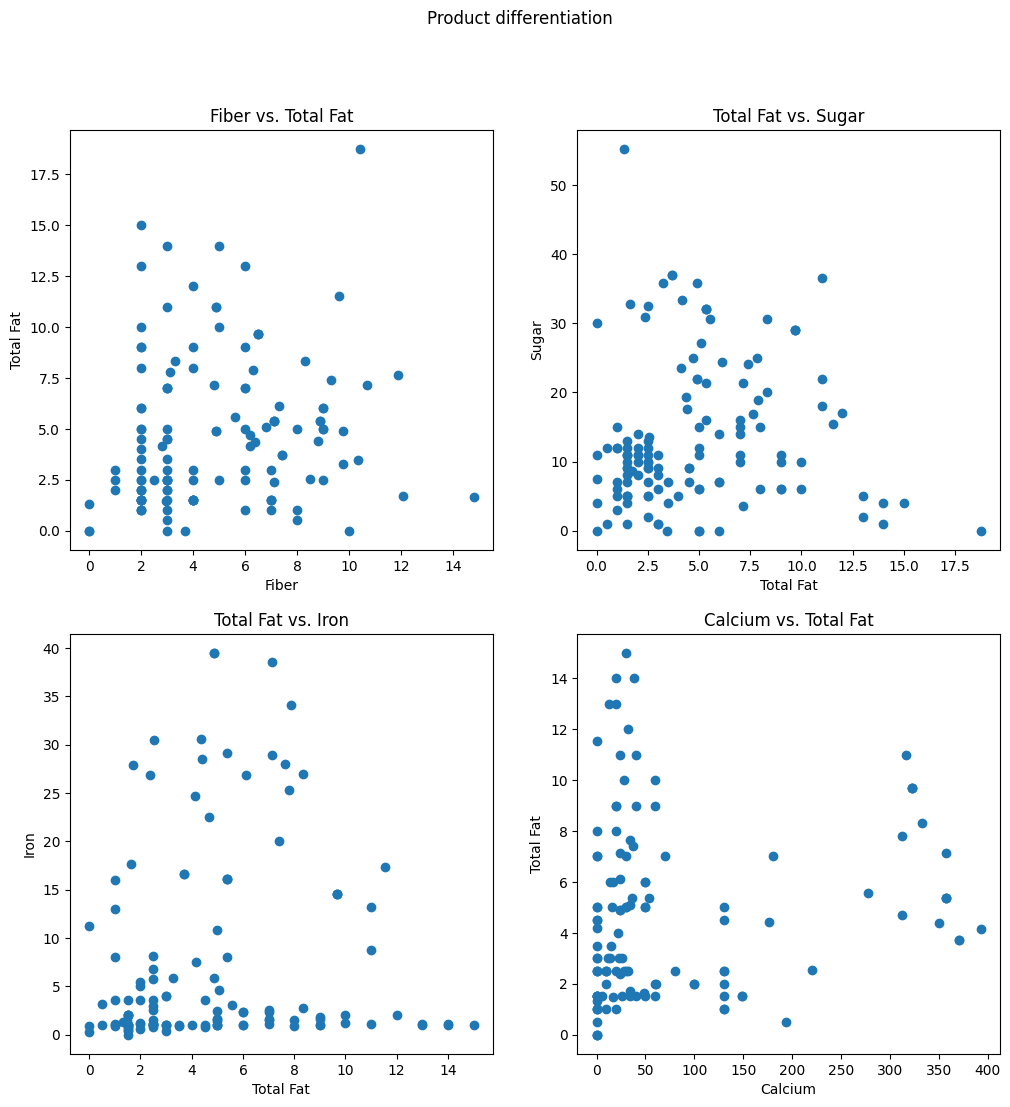

In [57]:
# scatter plots for fat:fiber, fat:sugar, fat:iron, calcium:fat

fig, axs = plt.subplots(2, 2, squeeze=False, figsize=(12,12)) 

axs[0,0].scatter(cereal['Fiber'], cereal['FAT'])
axs[0,0].set_title("Fiber vs. Total Fat")
axs[0,0].set_xlabel("Fiber")
axs[0,0].set_ylabel("Total Fat")

axs[0,1].scatter(cereal['FAT'], cereal['SUGAR'])
axs[0,1].set_title("Total Fat vs. Sugar")
axs[0,1].set_xlabel("Total Fat")
axs[0,1].set_ylabel("Sugar")


axs[1,0].scatter(cereal['FAT'], cereal['Iron'])
axs[1,0].set_title("Total Fat vs. Iron" )
axs[1,0].set_xlabel("Total Fat")
axs[1,0].set_ylabel("Iron")


axs[1,1].scatter(cereal['Calcium'], cereal['FAT'])
axs[1,1].set_title("Calcium vs. Total Fat" )
axs[1,1].set_xlabel("Calcium")
axs[1,1].set_ylabel("Total Fat")


fig.suptitle('Product differentiation')
plt.show()

### 2.2 K-Means clustering
Using the K-means clustering technique analyze the degree of product differ- entiation. Based on descriptive statistics, data availability, and scatter plots, choose pairs of features (i.e., nutrition facts) on which you believe the sellers differentiate themselves. Quantify your answer. You should try different K parameters. Report the goodness of fit (total sum of errors).

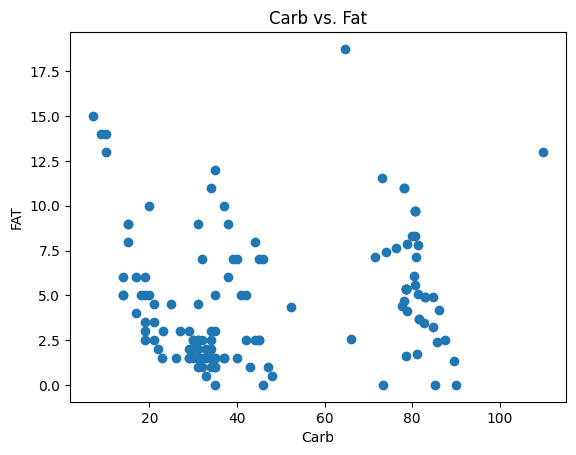

In [58]:
# scatter plot
plt.scatter(cereal['Carb'], cereal['FAT'])
plt.title("Carb vs. Fat")
plt.xlabel("Carb")
plt.ylabel("FAT")

plt.show()

In [59]:
features = ['Carb','FAT']
small_df = cereal[features]

n,c = cereal.shape

In [60]:
m = small_df.min()
M = small_df.max()

# Note: if you have more than two features, you would like to put the following in a loop:
print(f"The variable {features[0]} is between {m[0]} and {M[0]}")
print(f"The variable {features[1]} is between {m[1]} and {M[1]}")

The variable Carb is between 7.0 and 110.0
The variable FAT is between 0.0 and 18.75


In [61]:
k = 4 #more on how to choose k appears later in this notebook

kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(small_df)
# Note:  K-means++ is a version of K-means algorithm which is more efficient

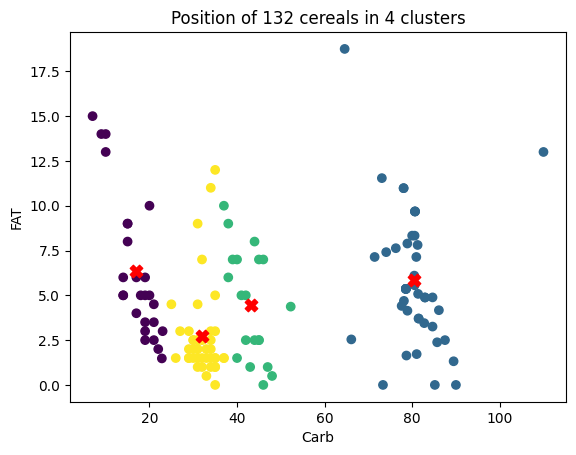

In [62]:
#scatter plot for the dataset
plt.scatter(data=cereal, x=features[0], y=features[1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],marker="X", c="r", s=80, label="centroids")
plt.title(f"Position of {n} cereals in {k} clusters")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

In [63]:
small_df.describe()

,Carb,FAT
count,132.000000,132.000000
mean,46.917863,4.750944
std,25.570862,3.645438
min,7.000000,0.000000
25%,29.750000,2.000000
50%,36.000000,4.070000
75%,78.232502,7.000000
max,110.000000,18.750000


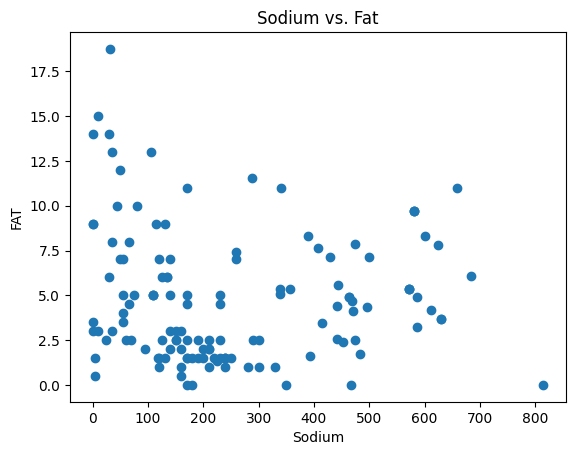

In [64]:
# scatter plot
plt.scatter(cereal['NA'], cereal['FAT'])
plt.title("Sodium vs. Fat")
plt.xlabel("Sodium")
plt.ylabel("FAT")

plt.show()

The variable NA is between 0.0 and 814.8148148148148
The variable FAT is between 0.0 and 18.75


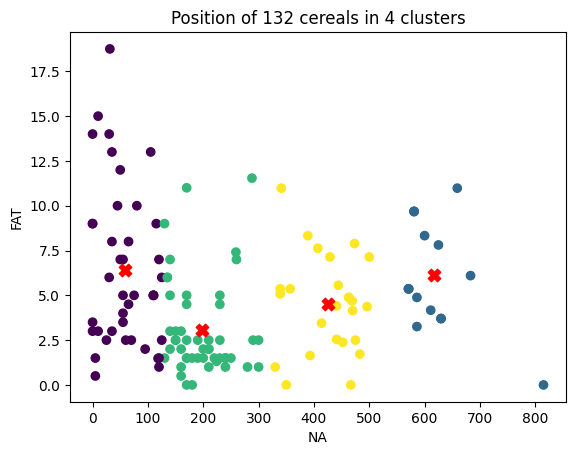

In [65]:
# Sodium vs FAt
features = ['NA','FAT']
small_df = cereal[features]

n,c = cereal.shape

m = small_df.min()
M = small_df.max()

# Note: if you have more than two features, you would like to put the following in a loop:
print(f"The variable {features[0]} is between {m[0]} and {M[0]}")
print(f"The variable {features[1]} is between {m[1]} and {M[1]}")

k = 4 #more on how to choose k appears later in this notebook

kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(small_df)
# Note:  K-means++ is a version of K-means algorithm which is more efficient

#scatter plot for the dataset
plt.scatter(data=cereal, x=features[0], y=features[1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],marker="X", c="r", s=80, label="centroids")
plt.title(f"Position of {n} cereals in {k} clusters")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()


In [66]:
small_df.describe()

,NA,FAT
count,132.000000,132.000000
mean,248.565546,4.750944
std,193.067782,3.645438
min,0.000000,0.000000
25%,110.000000,2.000000
50%,190.000000,4.070000
75%,396.500000,7.000000
max,814.814815,18.750000


## 3 Conclusions
Summarize your findings and draw conclusions from them. What can you recommend to cereal producers on the market? Do you find this market to be saturated? Here, I leave it to you to analyze your findings as you see fit. Given all the effort you have put, This section should be as very important.

- Based on the clusters, there is a lot of oversaturation. Most of the products have very similar nutrition facts. 
- Given many of the nutrition facts are highly correlated with calories/energy, it seems that cereals in the market are not differentiated on calories.
- Total fat has a very low correlation with carbs, sodium, and sugar. Therefore, it seems as though total fat is a good nutrition fact for producers to differentiate their products.
- There is more product differentiation for sodium and fat as the clusters are not as concentrated.
- Poducers should also cross reference these results with sales to see how they can optimize the products better when entering the market.